In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/"
sys.path.append(PATH_FOR_PROJECT)

In [2]:
from tqdm import tqdm
import itertools

from models.model_data_feeder import *
from visualisations.visualisations import Visualisator
from models.training_tools.early_stopping import EarlyStopping


# 0. Define experiment parameters

In [3]:
from models.script_parameters.parameters import ExperimentParameters

In [4]:
IS_DROPOUT_WITH_CORRELATION = True
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()

experiment_params.path = "/home/louis/Documents/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/models/LSTM_BayesRegressor/.models/"

path_results = "/home/louis/Documents/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/models/LSTM_BayesRegressor/"


experiment_params.version = "v0.1.0"
experiment_params.show_figures = True
experiment_params.smoke_test = False
experiment_params.train_lstm = True
experiment_params.save_lstm = False
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data




# 1.  generate data from ARMA process

In [5]:
from data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from data_generation.data_generators_switcher import DatageneratorsSwitcher

In [6]:
n_data = 1000
length_of_sequences = 7 + 1

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


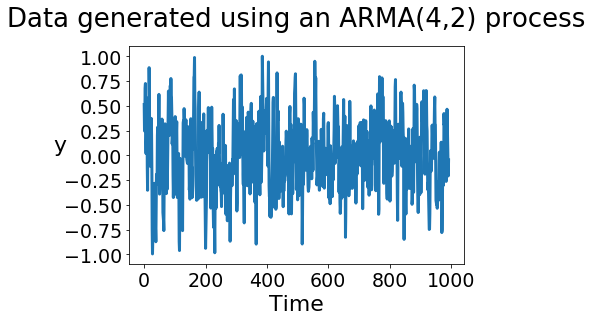

In [7]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(0.5*n_data)
val_set_end = floor(0.7*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 2 . Train model

## 2.1 Define parameters of model and optimizer

In [8]:
from models.regression.LSTM_CorrelatedDropout.LSTM_not_correlated_dropout import LSTM_not_correlated_dropout
from models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianNoCorrelations

from models.regression.LSTM_CorrelatedDropout.LSTM_correlated_dropout import LSTM_correlated_dropout
from models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianWithCorrelations

from models.lstm_params import LSTM_parameters

In [9]:
lstm_params = LSTM_parameters()
lstm_params.batch_size = 20
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.0

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)

learning_rate = 1e-3
num_epochs = 2000 if not experiment_params.smoke_test else 1
num_epochs_pretraining = 1000 if not experiment_params.smoke_test else 1

In [10]:
if IS_DROPOUT_WITH_CORRELATION:
    model = LSTM_correlated_dropout(lstm_params)
else:
    model = LSTM_not_correlated_dropout(lstm_params)

In [11]:
model.cuda()
model.show_summary()

weights mu:  tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)
covariance:  tensor([[0.0747, 0.0800, 0.0761, 0.0758, 0.0784, 0.0776],
        [0.0800, 0.1244, 0.1069, 0.1021, 0.1109, 0.1127],
        [0.0761, 0.1069, 0.1386, 0.1328, 0.1153, 0.1253],
        [0.0758, 0.1021, 0.1328, 0.1396, 0.1274, 0.1367],
        [0.0784, 0.1109, 0.1153, 0.1274, 0.1699, 0.1585],
        [0.0776, 0.1127, 0.1253, 0.1367, 0.1585, 0.1995]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)


In [12]:
if IS_DROPOUT_WITH_CORRELATION:
    loss_fn = LossRegressionGaussianWithCorrelations(1.0, lstm_params.hidden_dim)
else:
    loss_fn = LossRegressionGaussianNoCorrelations(1.0, lstm_params.hidden_dim)

In [13]:
params = list(model.parameters()) + list(model.prediction_sigma)

optimizer_1 = torch.optim.Adam(itertools.chain(model.parameters(),[model.weights_mu]),
                             lr=learning_rate)

optimizer_2 = torch.optim.Adam([model.weights_mu,
                                                                   model.prediction_sigma,
                                                                  model.covariance_factor],
                             lr=5*learning_rate, 
                               eps=1e-3)

loss_function_pretraining = torch.nn.MSELoss(size_average=False)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## 2.2 Pretraining of LSTM with auxiliary loss

In [14]:
from sklearn.metrics import mean_squared_error

if experiment_params.train_lstm:

    hist_1 = np.zeros(num_epochs_pretraining)
    for epoch in tqdm(range(num_epochs_pretraining)):
        model.hidden = model.init_hidden()
        
        if epoch % 10 == 0:
            
            losses_val, N_data_val = make_forward_pass(data_loader_sequences,
                                               model,
                                               loss_function_pretraining,
                                               data_validation,
                                               lstm_params.batch_size)
            
            val_loss = losses_val/N_data_val
            #print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper(epoch, val_loss, model)

            if early_stopper.early_stop:
                break
                
        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_function_pretraining, data_train,
                                                           lstm_params.batch_size)
        
                
        hist_1[epoch] = losses

        optimizer_1.zero_grad()
        losses.backward()
        optimizer_1.step()

    model.is_pretraining = False
    model.show_summary()

 43%|████▎     | 434/1000 [00:16<00:22, 25.50it/s]

EarlyStopping counter: 1 out of 4


 44%|████▍     | 443/1000 [00:17<00:22, 24.30it/s]

EarlyStopping counter: 2 out of 4


 46%|████▌     | 455/1000 [00:17<00:22, 24.74it/s]

EarlyStopping counter: 3 out of 4


 46%|████▌     | 458/1000 [00:17<00:22, 24.08it/s]

EarlyStopping counter: 4 out of 4
Validation loss decreased (inf --> 0.052818).  Saving model ...
weights mu:  tensor([ 0.5118, -0.4002, -0.3237, -0.3966, -0.3622,  0.1522], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.0747, 0.0800, 0.0761, 0.0758, 0.0784, 0.0776],
        [0.0800, 0.1244, 0.1069, 0.1021, 0.1109, 0.1127],
        [0.0761, 0.1069, 0.1386, 0.1328, 0.1153, 0.1253],
        [0.0758, 0.1021, 0.1328, 0.1396, 0.1274, 0.1367],
        [0.0784, 0.1109, 0.1153, 0.1274, 0.1699, 0.1585],
        [0.0776, 0.1127, 0.1253, 0.1367, 0.1585, 0.1995]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)


## 2.2 Training of bayesian parameters with variational loss

In [15]:
if experiment_params.train_lstm:
    
    early_stopper_2 = EarlyStopping(patience=10, verbose=True)

    
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()
        
        if epoch % 10 == 0:
            losses_val, N_data_val = make_forward_pass_output_specific(data_loader_sequences,
                                                               model,
                                                               loss_fn,
                                                               data_validation,
                                                               lstm_params.batch_size)
            
            val_loss = losses_val/N_data_val
            #print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper_2(epoch, val_loss, model)

            if early_stopper_2.early_stop:
                break
                
        losses, N_data = make_forward_pass_output_specific(data_loader_sequences,
                                                           model,
                                                           loss_fn,
                                                           data_train,
                                                           lstm_params.batch_size)
        
        
                
        hist[epoch] = losses

        optimizer_2.zero_grad()
        losses.backward()
        optimizer_2.step()


  2%|▏         | 40/2000 [00:30<27:12,  1.20it/s]

EarlyStopping counter: 1 out of 10



  4%|▎         | 70/2000 [00:55<25:16,  1.27it/s]

EarlyStopping counter: 1 out of 10



  4%|▍         | 90/2000 [01:10<23:08,  1.38it/s]

EarlyStopping counter: 1 out of 10



  5%|▌         | 100/2000 [01:19<24:49,  1.28it/s]

EarlyStopping counter: 2 out of 10



  6%|▌         | 110/2000 [01:27<24:13,  1.30it/s]

EarlyStopping counter: 3 out of 10



  6%|▌         | 120/2000 [01:34<23:11,  1.35it/s]

EarlyStopping counter: 4 out of 10



  6%|▋         | 130/2000 [01:42<23:00,  1.36it/s]

EarlyStopping counter: 5 out of 10



  7%|▋         | 140/2000 [01:49<22:32,  1.38it/s]

EarlyStopping counter: 6 out of 10



  8%|▊         | 160/2000 [02:05<26:55,  1.14it/s]

EarlyStopping counter: 1 out of 10



  8%|▊         | 170/2000 [02:14<24:31,  1.24it/s]

EarlyStopping counter: 2 out of 10



  9%|▉         | 180/2000 [02:22<25:33,  1.19it/s]

EarlyStopping counter: 3 out of 10



 10%|▉         | 190/2000 [02:30<22:42,  1.33it/s]

EarlyStopping counter: 4 out of 10



 10%|█         | 200/2000 [02:38<23:27,  1.28it/s]

EarlyStopping counter: 5 out of 10



 10%|█         | 210/2000 [02:46<22:10,  1.35it/s]

EarlyStopping counter: 6 out of 10



 12%|█▏        | 230/2000 [03:02<25:12,  1.17it/s]

EarlyStopping counter: 1 out of 10



 12%|█▏        | 240/2000 [03:10<22:32,  1.30it/s]

EarlyStopping counter: 2 out of 10



 12%|█▎        | 250/2000 [03:18<23:04,  1.26it/s]

EarlyStopping counter: 3 out of 10



 13%|█▎        | 260/2000 [03:26<21:34,  1.34it/s]

EarlyStopping counter: 4 out of 10



 14%|█▎        | 270/2000 [03:34<24:17,  1.19it/s]

EarlyStopping counter: 5 out of 10



 14%|█▍        | 280/2000 [03:43<23:32,  1.22it/s]

EarlyStopping counter: 6 out of 10



 14%|█▍        | 290/2000 [03:51<25:28,  1.12it/s]

EarlyStopping counter: 7 out of 10



 15%|█▌        | 300/2000 [03:59<21:59,  1.29it/s]

EarlyStopping counter: 8 out of 10



 16%|█▌        | 310/2000 [04:07<21:19,  1.32it/s]

EarlyStopping counter: 9 out of 10



 16%|█▌        | 320/2000 [04:15<22:46,  1.23it/s]

EarlyStopping counter: 10 out of 10
Validation loss decreased (inf --> 10.276925).  Saving model ...


## 2.3 Saving or loading of model if specified

In [16]:
from models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [17]:
if not experiment_params.train_lstm:

    load_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)



# 3. Anlysis of results

In [18]:
y_pred, y_true = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)

number_of_train_data = floor(0.7*n_data)
y_train, y_test = y_true[:number_of_train_data], y_true[number_of_train_data:]

model.show_summary()

weights mu:  tensor([ 0.5373, -0.4374, -0.3260, -0.4304, -0.3656,  0.1505], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.0940, 0.0879, 0.0851, 0.1070, 0.1141, 0.0961],
        [0.0879, 0.0967, 0.0818, 0.0912, 0.0998, 0.0836],
        [0.0851, 0.0818, 0.1025, 0.1183, 0.1021, 0.0875],
        [0.1070, 0.0912, 0.1183, 0.1726, 0.1642, 0.1224],
        [0.1141, 0.0998, 0.1021, 0.1642, 0.2223, 0.1485],
        [0.0961, 0.0836, 0.0875, 0.1224, 0.1485, 0.1224]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0872], device='cuda:0', requires_grad=True)


## 3.1 Loss convergence

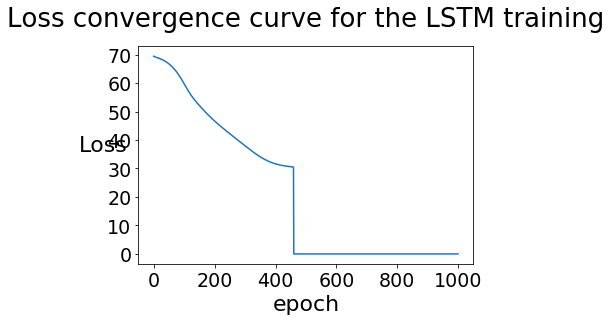

In [19]:

if experiment_params.show_figures:

    if experiment_params.train_lstm:

        Visualisator.show_epoch_convergence(data=hist_1,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=0)

        

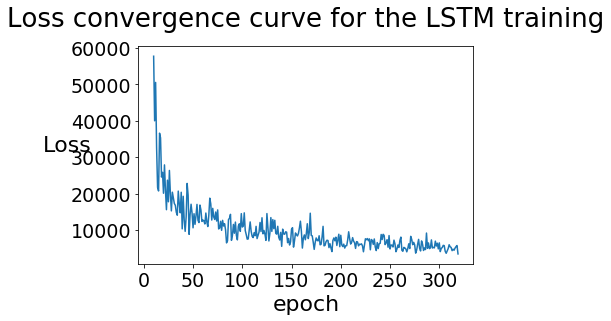

In [20]:
Visualisator.show_epoch_convergence(data=hist[:epoch],
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=10)

## 3.2 Visualisation of results with confidence interval

In [21]:
from probabilitic_predictions.probabilistic_predictions_regression import ProbabilisticPredictionsRegression

In [22]:
%matplotlib qt 

predictions = ProbabilisticPredictionsRegression()
predictions.number_of_predictions = y_pred.shape[0]
predictions.number_of_samples = y_pred.shape[1]
predictions.initialize_to_zeros()

predictions.values = y_pred
predictions.true_values = y_true
predictions.show_predictions_with_confidence_interval(0.95)

## 3.3 Calibration analysis

In [23]:
from models.calibration.diagnostics import calculate_one_sided_cumulative_calibration, calculate_confidence_interval_calibration, calculate_marginal_calibration
from models.calibration.analysis import show_analysis

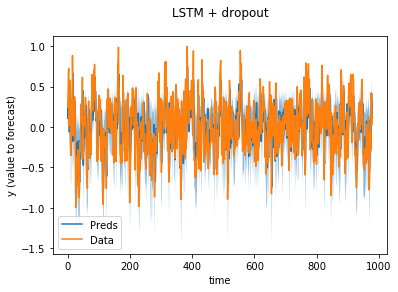

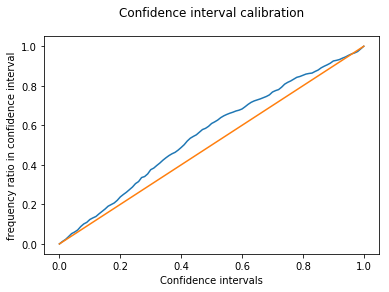

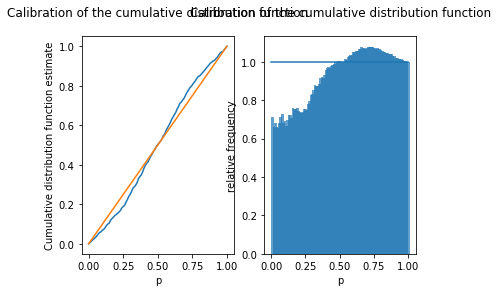

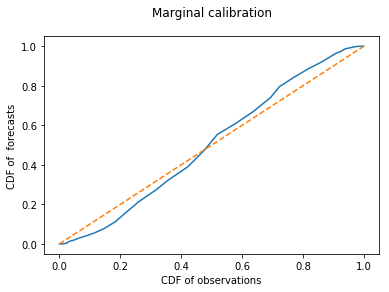

 deviation_score_probabilistic_calibration: 0.05577 
 deviation_score_exceedance_calibration: 0.03129 
 deviation_score_marginal_calibration: 0.04397 


In [24]:
%matplotlib inline 

deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)



show_analysis(predictions.values, predictions.true_values, name="LSTM + dropout")

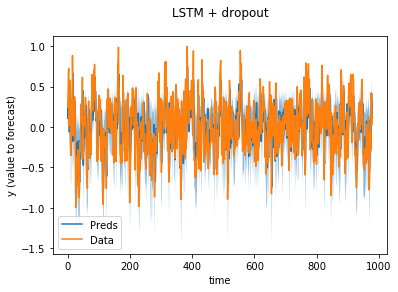

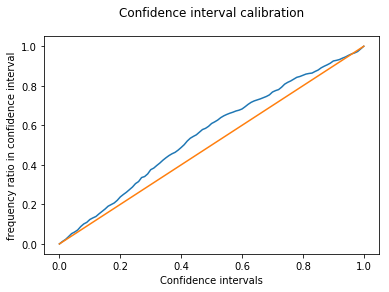

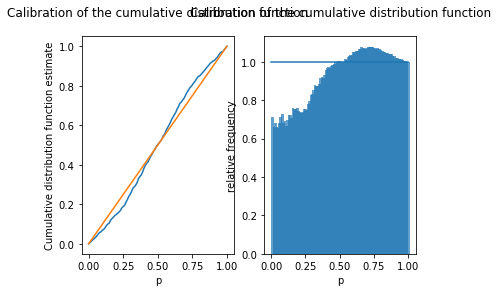

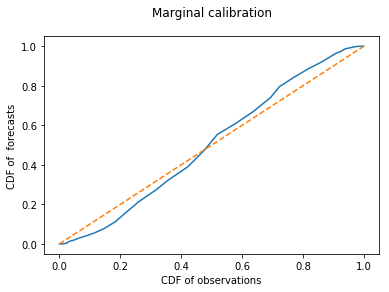

 deviation_score_probabilistic_calibration: 0.05577 
 deviation_score_exceedance_calibration: 0.03129 
 deviation_score_marginal_calibration: 0.04397 


In [25]:
show_analysis(predictions.values, predictions.true_values, name="LSTM + dropout")

In [26]:
%matplotlib qt

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

In [27]:
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
